### Ref http://learningtensorflow.com/lesson4/

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    for i in range(n_clusters):
        samples = tf.random_normal((n_samples_per_cluster, n_features),
                                   mean=0.0, stddev=5.0, dtype=tf.float32, seed=seed, name="cluster_{}".format(i))
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor/2)
        centroids.append(current_centroid)
        samples += current_centroid
        slices.append(samples)
    samples = tf.concat(slices, 0, name='samples')
    centroids = tf.concat(centroids, 0, name='centroids')
    return centroids, samples

In [3]:
def plot_clusters(all_samples, centroids, n_samples_per_cluster):
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = all_samples[i * n_samples_per_cluster : (i + 1) * n_samples_per_cluster]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color='m', mew=5)
    plt.show()

In [4]:
def choose_random_centroids(samples, n_clusters):
    with tf.name_scope('random_index'):
        n_samples = tf.shape(samples)[0]
        random_indices = tf.random_shuffle(tf.range(0, n_samples))
        begin = [0,]
        size = [n_clusters,]
        size[0] = n_clusters
        centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids

In [5]:
def assign_to_nearest(samples, centroids):
    
    with tf.name_scope('find_cluster'):
        # START from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
        expanded_vectors = tf.expand_dims(samples, 0, name="samples") #[1, sample_size, feature_size]
        expanded_centroids = tf.expand_dims(centroids, 1, name="centroids") #[K, 1, feature_size]

        with tf.name_scope('distance'):
            #expanded_vectors - expanded_centroids = ผลที่จะได้เป็นการนำ centroid แต่ละตัวมา Loop แล้วลบกับ input แต่ละตัว
            # [K, sample_size, feature_size]
            subtract = tf.subtract(expanded_vectors, expanded_centroids)

            #sum depth dimension then reduce to 2 dimension [K, sample_size]
            distances = tf.reduce_sum( tf.square(subtract), 2)

        #which row has the lowest distance compare each column
        mins = tf.argmin(distances, 0, name='find_cluster')
        # END from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
        nearest_indices = mins
    return nearest_indices

In [6]:
def update_centroids(samples, nearest_indices, n_clusters):
#     with tf.name_scope('update_centroid'):
    # Updates the centroid to be the mean of all samples associated with it.
    nearest_indices = tf.to_int32(nearest_indices)
    #classify sample into each cluster set [[1 2], [3, 4], [5 6], ...]
    #nearest_indices = list of each sample cluster [0, 1, 2, 1, ...]
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)

    #calculate mean for each cluster
    new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions], 0)
    return new_centroids

In [7]:
def k_mean(samples, centroid_value, n_clusters):
    with tf.name_scope('k_mean'):
        cluster = assign_to_nearest(samples, centroid_value)            
        centroid_value = update_centroids(samples, cluster, n_clusters)
    return centroid_value

In [8]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

np.random.seed(seed)

with tf.name_scope('input'):
    centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)

with tf.name_scope('centroid'):
    initial_centroids = choose_random_centroids(samples, n_clusters)

In [9]:
model = tf.global_variables_initializer()
with tf.Session() as session:
    centroid_history = []
    centroid_value = initial_centroids
    centroid_history.append(centroid_value)
    with tf.name_scope('train'):
        for i in xrange(2):
            print "epoch : ", i + 1
            centroid_value = k_mean(samples, centroid_value, n_clusters)
    centroid_value = session.run(centroid_value)
            

epoch :  1
epoch :  2


<IPython.core.display.Javascript object>


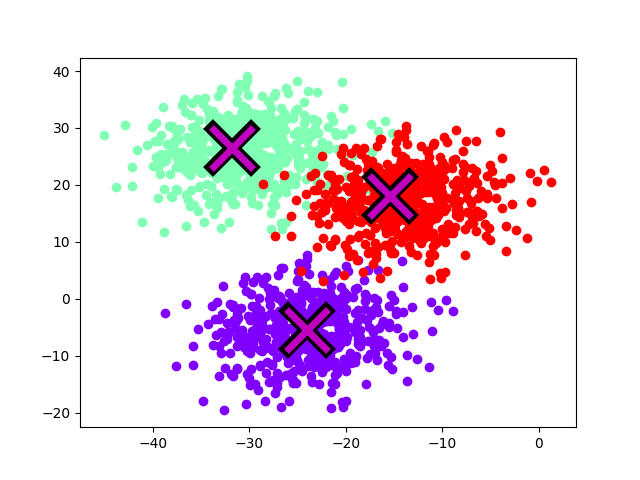

In [10]:
with tf.Session() as session:
    sample_values, y = session.run([samples, centroids])
    plot_clusters(sample_values, centroid_value, n_samples_per_cluster)

In [11]:
logs_path = "/tmp/tensorflow/"
writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

<img src="tensorboard_k_mean.png">